Vgg 모델을 사용하여 훈련이 잘 된 모델과 잘 안된 모델을 비교한다.   

비교 방법 : Confusion_Matrix, feature_map, grad_cam

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-rc1
!pip install tf-hub-nightly
!pip install -q h5py pyyaml

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
from glob import glob
import pathlib

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


%matplotlib inline

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 501kB 18.2MB/s 
     |████████████████████████████████| 4.3MB 51.4MB/s 
     |████████████████████████████████| 102kB 2.7MB/s 


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = '/content/gdrive/My Drive/dataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')


In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test= num_cats_test + num_dogs_test

print(total_train)
print(total_val)
print(total_test)

17000
4000
4000


In [0]:
#하이퍼파라미터 초기화
batch_size = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_image_generator = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 17000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


#모델_만들기

vgg16_model : 비교적 정확도가 높은 모델   
vgg16_model_1 : 비교적 정확도가 낮은 모델

In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf

input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')
def vgg16_model(input_data):
  x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_data)
  x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)
 
  x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = GlobalAveragePooling2D()(x)
  x = Dense(2048, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(1, activation='sigmoid')(x)

  return Model(input_data, x)

In [10]:
vgg16 = vgg16_model(input_tensor)

optimizer = optimizers.SGD(lr=0.001, momentum=0.9)

vgg16.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584

In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf

input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')
def vgg16_model_2(input_data):
  x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_data)
  x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)
 
  x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = GlobalAveragePooling2D()(x)
  x = Dense(2048, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(1, activation='sigmoid')(x)

  return Model(input_data, x)

In [30]:
vgg16_1 = vgg16_model_2(input_tensor)

optimizer = optimizers.SGD(lr=0.001, momentum=0.9)

vgg16_1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

vgg16_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_30 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 112, 112, 128)     1475

In [13]:
#체크포인트 설정
checkpoint_path = "/content/gdrive/My Drive/dataset/cps9-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, svae_weights_only=True,
    period=5)

vgg16.save_weights(checkpoint_path.format(epoch=0))
history = vgg16.fit_generator(
    train_data_gen,
    steps_per_epoch = 80,
    epochs=240,
    validation_data = val_data_gen,
    validation_steps = 20,
    callbacks = [cp_callback]
)

vgg16.save('/content/gdrive/My Drive/dataset/vgg16_model_240.h5')

Epoch 1/240
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
80/80 [==============================] - 441s 6s/step - loss: 0.7790 - accuracy: 0.5888 - val_loss: 0.7623 - val_accuracy: 0.4750
Epoch 2/240
80/80 [==============================] - 294s 4s/step - loss: 0.7699 - accuracy: 0.5881 - val_loss: 0.6953 - val_accuracy: 0.5625
Epoch 3/240
80/80 [==============================] - 330s 4s/step - loss: 0.7551 - accuracy: 0.6050 - val_loss: 0.7077 - val_accuracy: 0.5500
Epoch 4/240
80/80 [==============================] - 365s 5s/step - loss: 0.7280 - accuracy: 0.5906 - val_loss: 0.7862 - val_accuracy: 0.5075
Epoch 5/240
79/80 [============================>.] - ETA: 4s - loss: 0.6890 - accuracy: 0.6203
Epoch 00005: saving model to /content/gdrive/My Drive/dataset/cps9-0005.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/dataset/cps9-0005.ckpt/as

In [14]:
#240_epoch
print("Evaluate")
scores = vgg16.evaluate_generator(test_data_gen, steps=200)
print("%s: %.2f%%" %(vgg16.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(vgg16.metrics_names[0], scores[0]*100))

Evaluate
accuracy: 94.98%
loss: 13.31%


In [31]:
# #체크포인트 설정
# checkpoint_path = "/content/gdrive/My Drive/dataset/cps9-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path, verbose=1, svae_weights_only=True,
#     period=5)

vgg16_1.save_weights(checkpoint_path.format(epoch=0))
history = vgg16_1.fit_generator(
    train_data_gen,
    steps_per_epoch = 1,
    epochs=1,
    validation_data = val_data_gen,
    validation_steps = 5
    #callbacks = [cp_callback]
)

vgg16_1.save('/content/gdrive/My Drive/dataset/vgg16_model_2.h5')

1/1 [==============================] - 2s 2s/step - loss: 0.9586 - accuracy: 0.3000 - val_loss: 0.6967 - val_accuracy: 0.5000


In [32]:
#2_epoch
print("Evaluate")
scores = vgg16_1.evaluate_generator(test_data_gen, steps=200)
print("%s: %.2f%%" %(vgg16_1.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(vgg16_1.metrics_names[0], scores[0]*100))

Evaluate
accuracy: 51.23%
loss: 69.35%


#confusion matrix

Confusion Matrix를 찍어본 결과 비교적 훈련이 잘된 모델 1의 경우와 훈련이 잘 안된 모델 2의 이미지 분류 차이를 한눈에 확인 할 수 있습니다. 모델 2의 경우 이진 분류이기에 잘 분간하지 못 할 때 무조건 1로 출력하는 모습이 보이는 듯 합니다

In [0]:
##############################################
# 저장된 모델 불러오기

#accuracy: 94.98% 의 모델
new_model = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/vgg16_model_240.h5')

#accuracy: 51.23% 의 모델
new_model_1 = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/vgg16_model_2.h5')

In [40]:
# 테스트셋 예측하기
print("Predict")
pred = new_model.predict_generator(test_data_gen, steps=200, verbose=1)

print("Predict_1")
pred_1 = new_model_1.predict_generator(test_data_gen, steps=200, verbose=1)

Predict
200/200 [==============================] - 28s 141ms/step
Predict_1
200/200 [==============================] - 29s 143ms/step


In [0]:
#분류 작업
predict_data = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data.append(1)
  else:
    predict_data.append(0)


predict_data_1 = []

for i in range(len(pred)):
  if pred_1[i] > 0.500:
    predict_data_1.append(1)
  else:
    predict_data_1.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

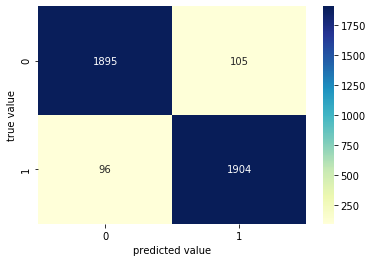

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Confusion Matrix")
conf_matrix = confusion_matrix(test_data_gen.classes, predict_data)
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

Confusion Matrix_1


Text(33.0, 0.5, 'true value')

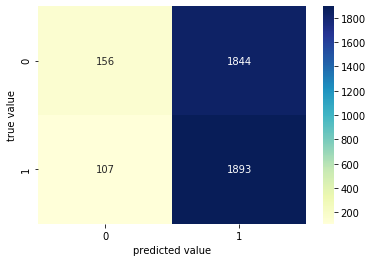

In [45]:
print("Confusion Matrix_1")
conf_matrix_1 = confusion_matrix(test_data_gen.classes, predict_data_1)
sns.heatmap(conf_matrix_1, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

#특징맵

(1, 224, 224, 3)


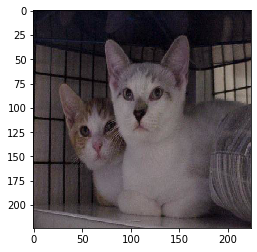

In [47]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
import numpy as np

test_image = '/content/gdrive/My Drive/dataset/test/cat/cat.81.jpg'

img = image.load_img(test_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img)
print(img_tensor.shape)

In [0]:
from tensorflow.python.keras import models

layer_outputs = [layer.output for layer in new_model.layers[:8]]
activation_model = models.Model(inputs=new_model.input, outputs=layer_outputs)

(1, 224, 224, 64)


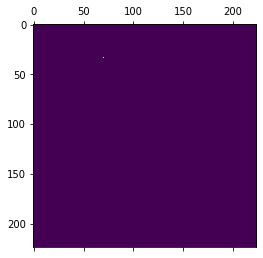

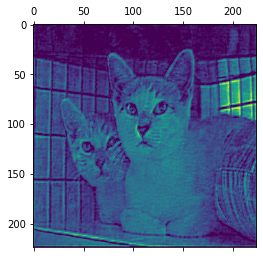

In [60]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[2]

print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 7], cmap = 'viridis')
plt.matshow(first_layer_activation[0, :, :, 50], cmap = 'viridis')
plt.show()

In [61]:
def Layer_predict(model, image):
  output_layers = [layer.output for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]
  output_names = [layer.name for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]

  show_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
  show_model_pred = show_model.predict(image)
  for pred_layer in show_model_pred:
    print(pred_layer.shape)
  return show_model_pred, output_names

layer_outputs, layer_names = Layer_predict(new_model, img_tensor)

(1, 224, 224, 64)
(1, 224, 224, 64)
(1, 112, 112, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)
(1, 56, 56, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 7, 7, 512)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


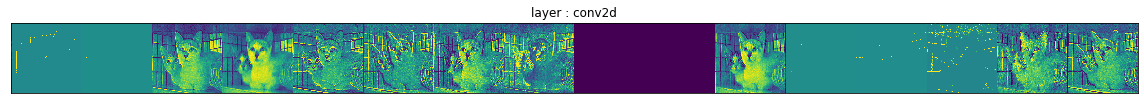

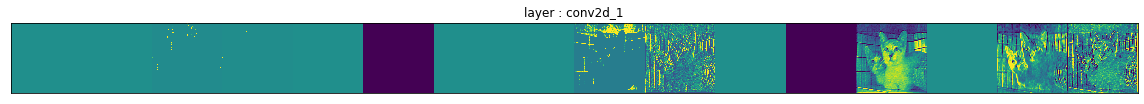

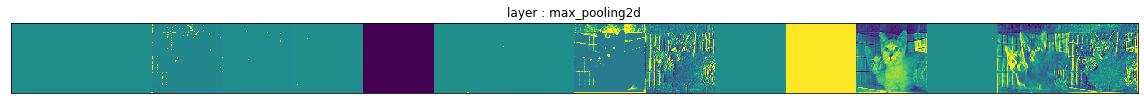

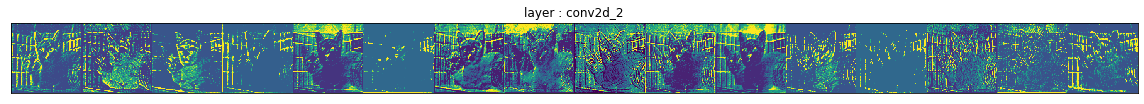

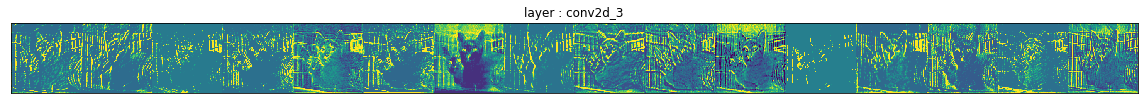

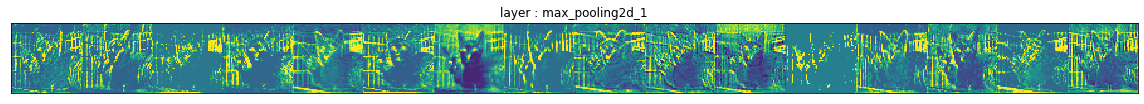

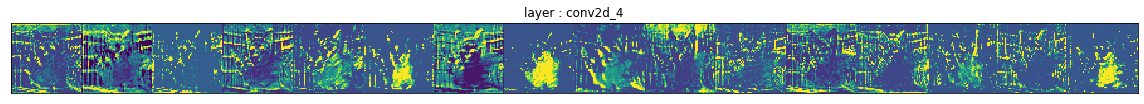

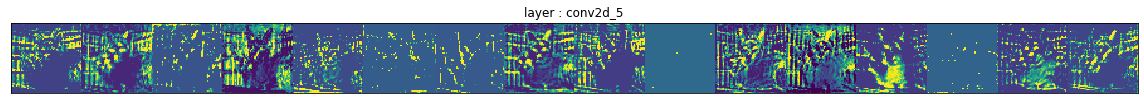

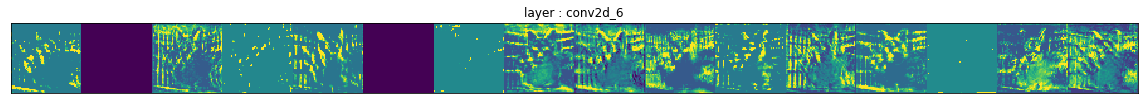

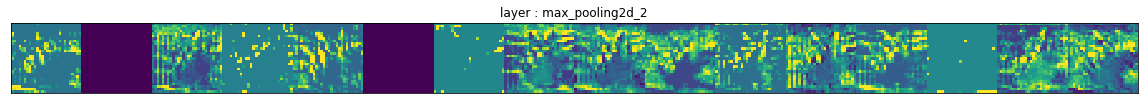

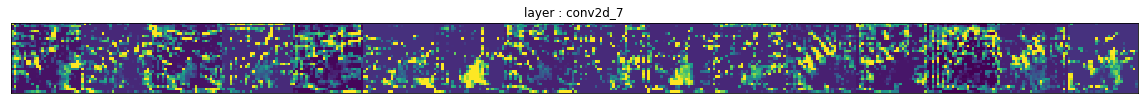

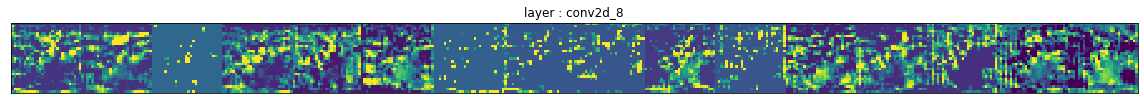

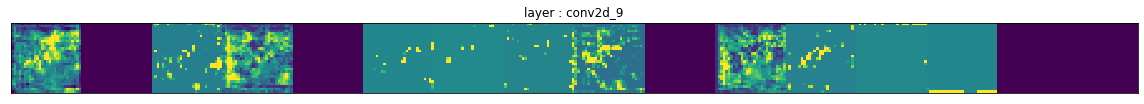

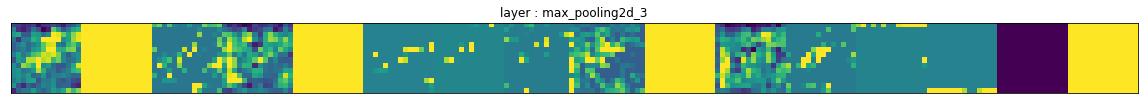

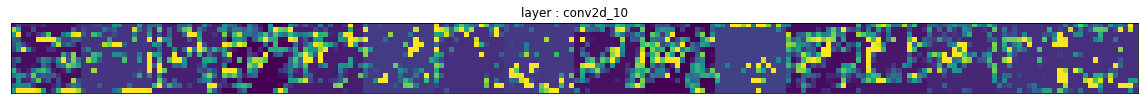

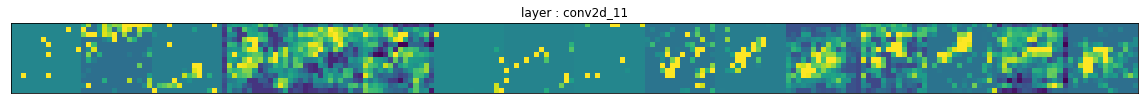

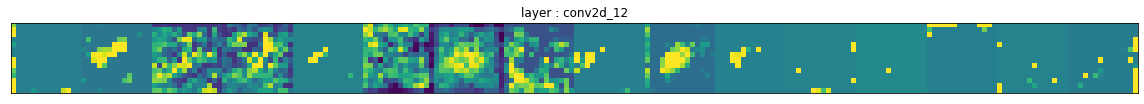

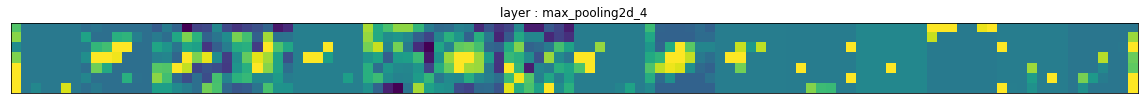

In [62]:
def show_predict_image(show_model_pred,output_names):
    n_col= 16
    _, size2, size, n_features = show_model_pred.shape
    n_row = n_features //n_col
    feature_map_image = np.zeros(shape=(size2,size*n_col),dtype=('uint8'))
    
    for row in range(1):
        for col in range(n_col):   
            input_fmi = show_model_pred[0,:,:,row*n_col+col]

            input_fmi -= input_fmi.mean()
            input_fmi /= input_fmi.std()
            input_fmi *= 64
            input_fmi += 128
            input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

            feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

    plt.figure(figsize=(n_col, n_row))
    plt.xticks([])
    plt.yticks([])
    plt.title('layer : {}'.format(output_names))
    plt.tight_layout()
    plt.imshow(feature_map_image,cmap='viridis')

for layer, name in zip(layer_outputs, layer_names):
  show_predict_image(layer, name)
plt.tight_layout()
plt.show()

In [0]:
from tensorflow.python.keras import models

layer_outputs_1 = [layer.output for layer in new_model_1.layers[:8]]
activation_model_1 = models.Model(inputs=new_model_1.input, outputs=layer_outputs_1)

(1, 224, 224, 64)


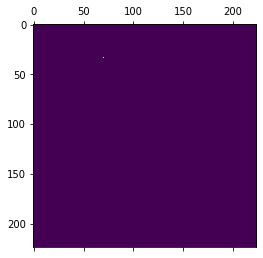

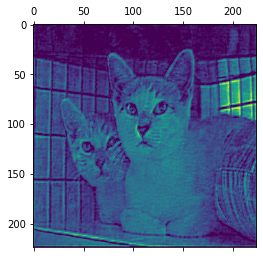

In [65]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[2]

print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 7], cmap = 'viridis')
plt.matshow(first_layer_activation[0, :, :, 50], cmap = 'viridis')
plt.show()

In [72]:
def Layer_predict(model, image):
  output_layers_1 = [layer.output for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]
  output_names_1 = [layer.name for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]

  show_model_1 = tf.keras.models.Model(inputs = model.input, outputs = output_layers_1)
  show_model_pred_1 = show_model_1.predict(image)
  for pred_layer in show_model_pred_1:
    print(pred_layer.shape)
  return show_model_pred_1, output_names_1

layer_outputs_1, layer_names = Layer_predict(new_model_1, img_tensor)

(1, 224, 224, 64)
(1, 224, 224, 64)
(1, 112, 112, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)
(1, 56, 56, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 7, 7, 512)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


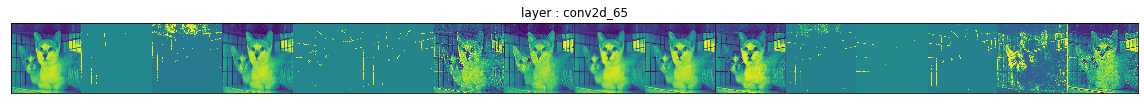

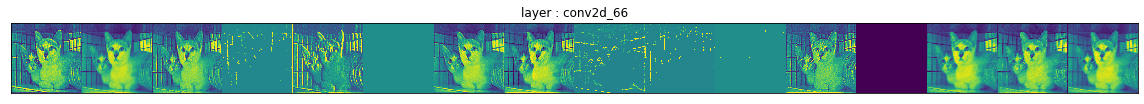

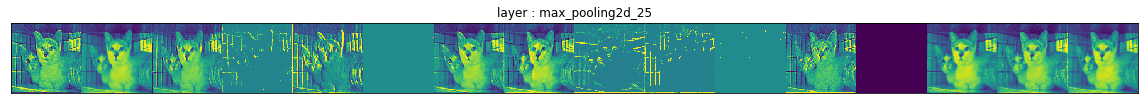

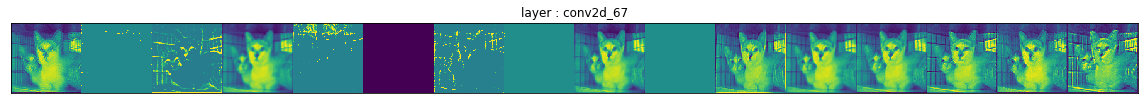

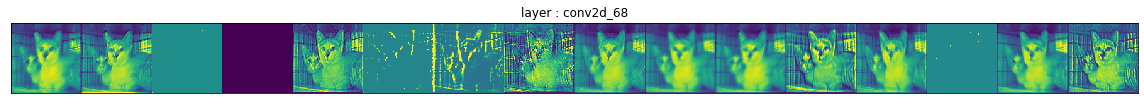

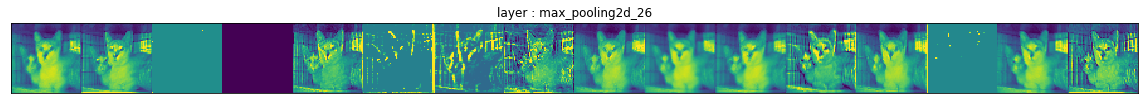

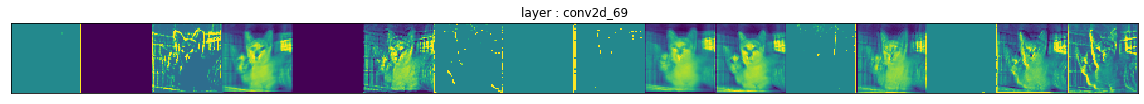

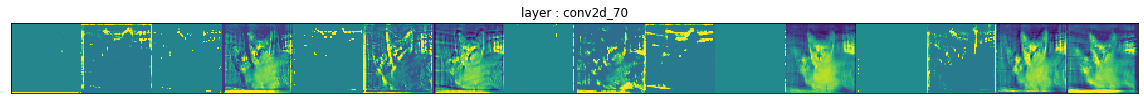

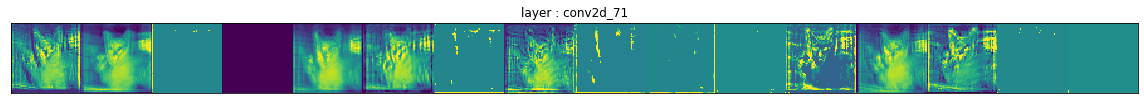

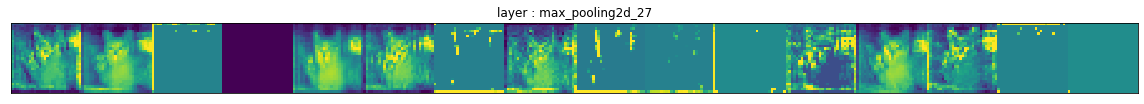

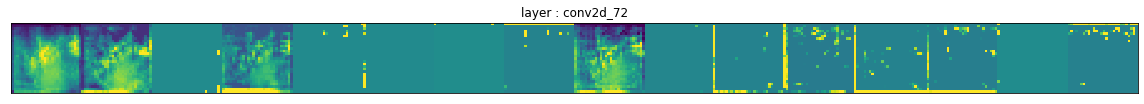

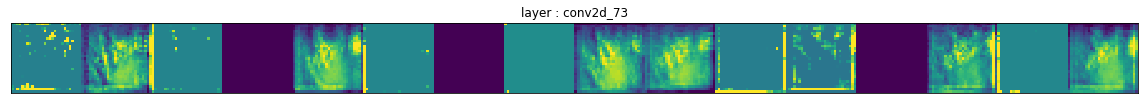

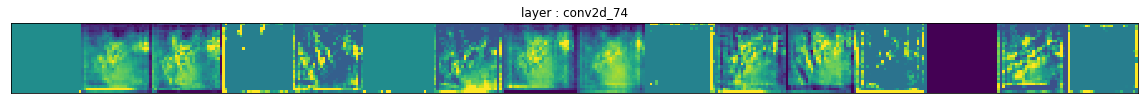

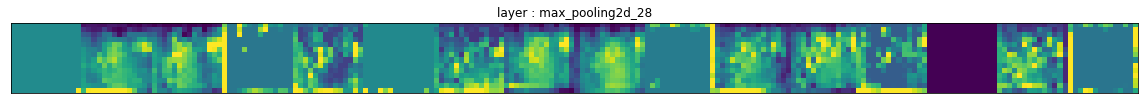

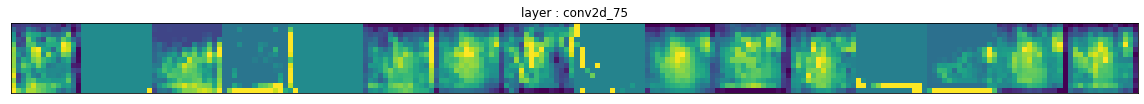

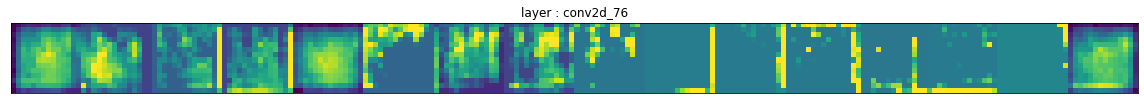

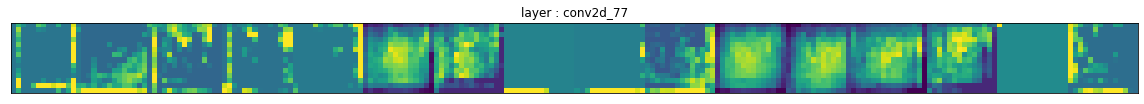

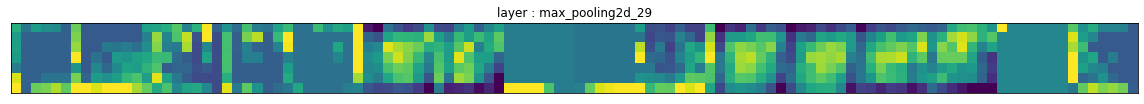

In [75]:
def show_predict_image(show_model_pred_1,output_names_1):
    n_col= 16
    _, size2, size, n_features = show_model_pred_1.shape
    n_row = n_features //n_col
    feature_map_image = np.zeros(shape=(size2,size*n_col),dtype=('uint8'))
    
    for row in range(1):
        for col in range(n_col):   
            input_fmi = show_model_pred_1[0,:,:,row*n_col+col]

            input_fmi -= input_fmi.mean()
            input_fmi /= input_fmi.std()
            input_fmi *= 64
            input_fmi += 128
            input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

            feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

    plt.figure(figsize=(n_col, n_row))
    plt.xticks([])
    plt.yticks([])
    plt.title('layer : {}'.format(output_names_1))
    plt.tight_layout()
    plt.imshow(feature_map_image,cmap='viridis')

for layer, name in zip(layer_outputs_1, layer_names):
  show_predict_image(layer, name)
plt.tight_layout()
plt.show()

#heatmap

모델1의 경우 대부분 얼굴을 집중적으로 보며 개 고양이를 분류하는데 반하여, 모델2의 경우 집중적으로 보는 곳이 없는 것 처럼 보인다.

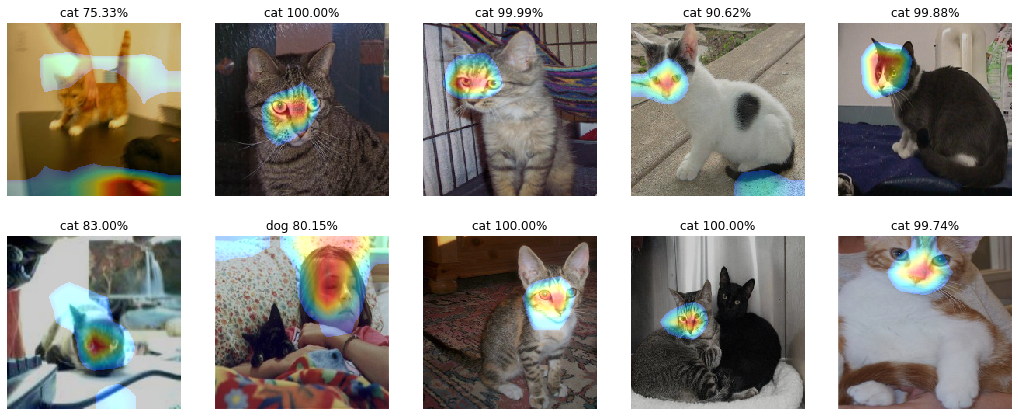

In [83]:
import cv2

plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [vgg16.inputs], [vgg16.get_layer(index=23).output, vgg16.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads = tape.gradient(loss, model_outputs)

  guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  prediction = predictions[0]
  model_outputs = model_outputs[0]
  plt.subplot(4, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads, axis=(1, 2))
  weights = weights.reshape(512, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.3
  cam /= 0.7

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])

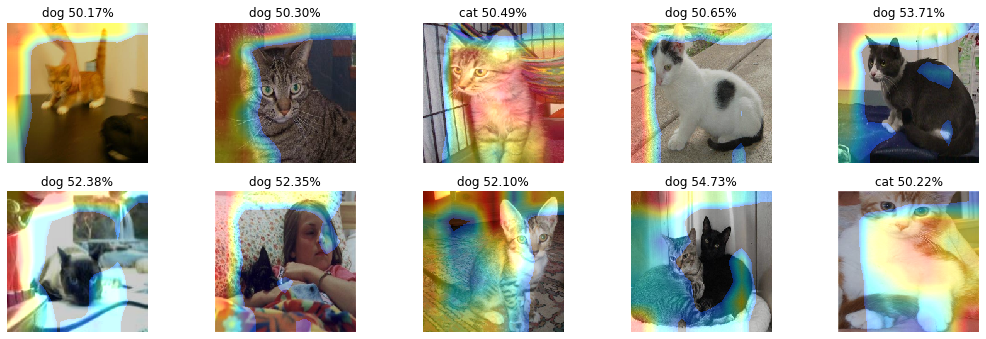

In [93]:
import cv2
plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [vgg16_1.inputs], [vgg16_1.get_layer(index=23).output, vgg16_1.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs_1, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads_1 = tape.gradient(loss, model_outputs_1)

  guided_grads = (
        tf.cast(model_outputs_1 > 0, "float32") * tf.cast(grads_1 > 0, "float32") * grads_1
  )

  prediction = predictions[0]
  model_outputs_1 = model_outputs_1[0]
  plt.subplot(5, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads_1, axis=(1, 2))
  weights = weights.reshape(512, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs_1, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.3
  cam /= 0.7

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])